In [13]:
from deap import gp, creator, base, tools, algorithms
import operator
import random
import math
import numpy
from mnist import MNIST
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
dataset = MNIST('dataset')
train_images, train_labels = dataset.load_training()
test_images, test_labels = dataset.load_testing()
train_images = [image.reshape(28,28) for image in np.copy(train_images)]
train_labels = np.copy(train_labels)
test_images = [image.reshape(28,28) for image in np.copy(test_images)]
test_labels = np.copy(test_labels)



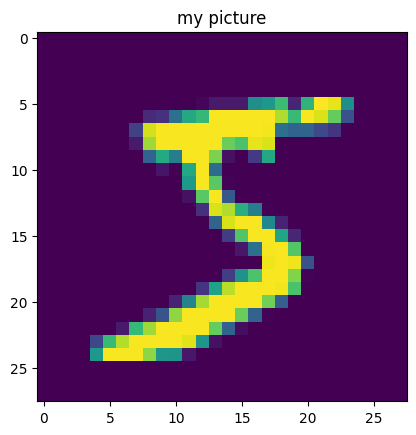

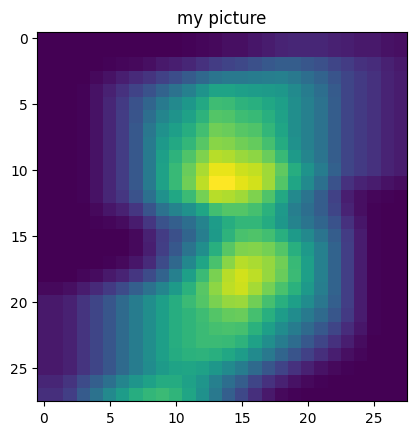

In [14]:
src = train_images[0]
dst = cv.blur(src, (10, 10))
plt.imshow(src)
plt.title('my picture')
plt.show()
plt.imshow(dst)
plt.title('my picture')
plt.show()

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [ ]:
def _protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
pset = gp.PrimitiveSet("MAIN", 1, "x")
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(_protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [ ]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [ ]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.fsum(sqerrors) / len(points),

In [ ]:
toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [ ]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

In [ ]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(10)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                                halloffame=hof, verbose=False)
print(log)